In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress annoying warnings from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Data Cleaning

Here we map the names of the animal classes in ```class.csv``` to their corresponding ids in ```zoo.csv```.

In [136]:
animals = pd.read_csv('../data/zoo.csv')
# animals.drop(['animal_name'], axis=1, inplace=True)

# animal_names = pd.read_csv('../data/zoo.csv').animal_name


classes = pd.read_csv('../data/class.csv')
classes.columns = [col.lower() for col in classes.columns]
classes = classes[['class_number', 'class_type']].rename({'class_type':'class_name', 'class_number':'class_type'}, axis=1)

animals = animals.merge(classes)

animal_names = animals[['animal_name', 'class_name']]

## Model Preparation

In [137]:
targets = animals.class_name.unique()
n_classes = len(targets)
features = animals.drop(['class_type', 'class_name', 'legs'], axis=1).columns

dummy_legs = pd.get_dummies(animals.legs, drop_first=True)
dummy_legs.columns = [str(col) + '_legs'  for col in dummy_legs.columns]

X = animals[features].join(dummy_legs)
y = animals.class_type.as_matrix()

## Define qualitative colors for plotting each class

In [17]:
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex

cmap = cm.get_cmap('Set1', 7)
colors = [rgb2hex(cmap(i)[:3]) for i in range(7)]

# Is our data linearly separable?

We can check if our model is linearly separable with three methods:

### Single Layer Perceptron

If our data is linearly separable, then we should be able to run it through a convergent single layer perceptron. A single layer perceptron will only converge if the input vectors are linearly separable. In this state, all input vectors would be classified correctly indicating linear separability. We will apply it on the entire dataset instead of splitting into train/test since our intent is to test for linear separability among the classes and not to build a model for future predictions. We don't have to do any feature scaling because all of our inputs are binary.

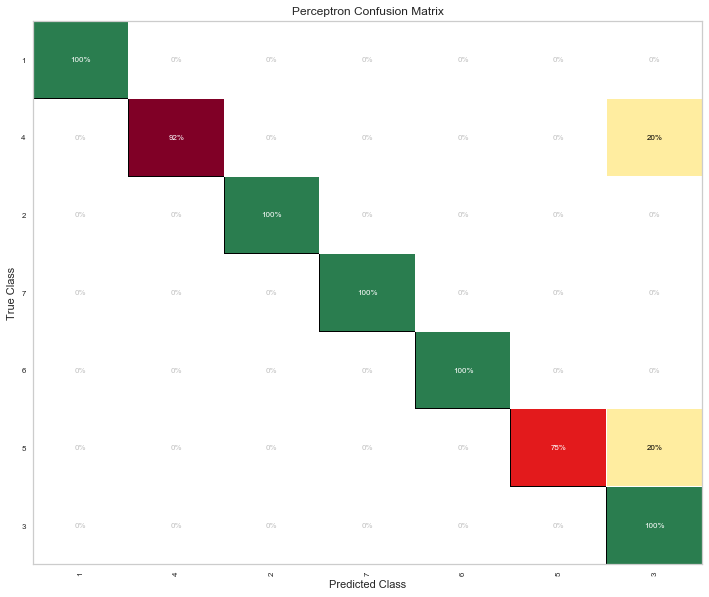

In [18]:
from sklearn.linear_model import Perceptron
from yellowbrick.classifier import ConfusionMatrix
perc = Perceptron(random_state=42)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(perc, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

In [19]:
print(animals.class_name.unique())

['Mammal' 'Fish' 'Bird' 'Invertebrate' 'Bug' 'Amphibian' 'Reptile']


The confusion matrix shows us that our data is not linearly separable. We mistook a fish for a reptile and a reptile for an amphibian.

## Linear Discriminant Analysis + Computational Geometry
The model will basically draw lines through the outer points of each class in lower-dimensional space to create the smallest possible polygon that encapsulates every point in the class. If any of the shapes overlap, the data is not linearly separable. To detect overlap, we use what's called the convex hull algorithm. The picture below demonstrates this concept:


![img](../img/linear_separability_demonstration.jpg)

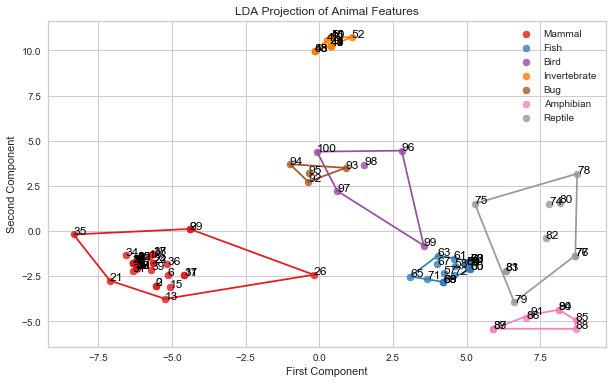

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.spatial import ConvexHull
import pylab as pl

X_r = LDA(n_components=2).fit_transform(X, y)

plt.clf()
plt.figure(figsize = (10, 6))
targets = animals.class_name.unique()
plt.title('LDA Projection of Animal Features')
plt.xlabel('First Component')
plt.ylabel('Second Component')

for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
    bucket = X_r[y == i, :]
    hull = ConvexHull(bucket)
    coords = list(zip(bucket[:,0], bucket[:,1], animals[animals.class_type == i].index))
    plt.scatter(bucket[:, 0], bucket[:, 1], color=color, alpha=.8, lw=.5, label=target)
    for x1,x2,ind in coords:
        pl.text(x1, x2, str(ind), color='black', fontsize=12)
    for j in hull.simplices:
        plt.plot(bucket[j,0], bucket[j,1], color)
plt.legend()
plt.show()

In [21]:
animal_names[93]

'vampire'

Turns out there's a vampire (bug) that's ruining all our fun...AKA linear separability!

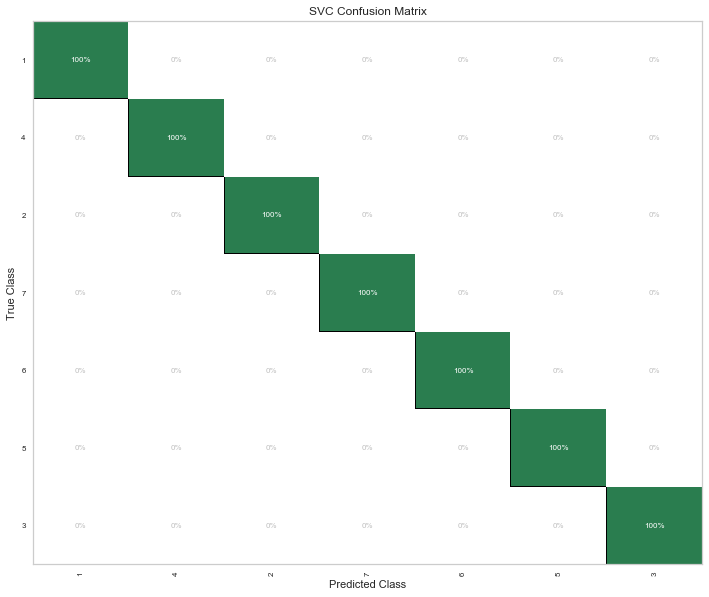

In [22]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', random_state=42)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

Sweet baby jesus we've done it. We have linear separability!

In [23]:
svc.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Linear Discriminant Analysis + Support Vector Machine (Linear Kernel)

Just for fun, let's see what happens when we transform our data with LDA before classifying it.

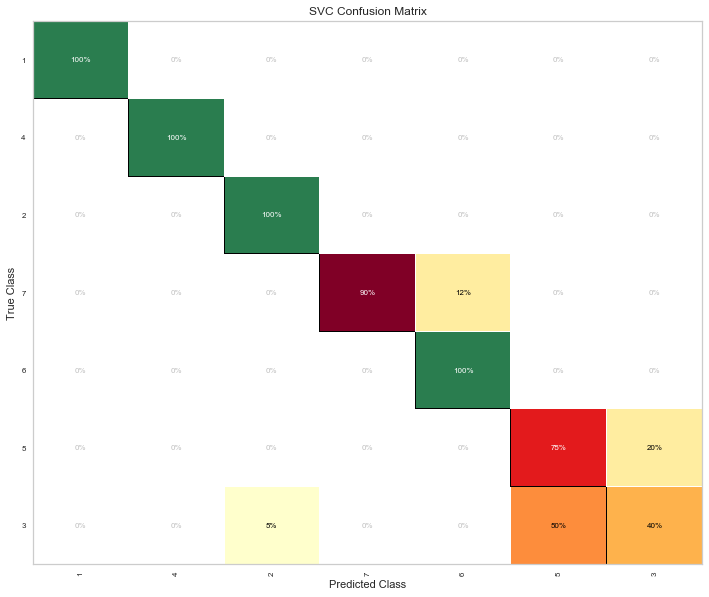

In [24]:
from sklearn.pipeline import make_pipeline
svc = make_pipeline(LDA(n_components=2), SVC(C=1, kernel='linear', random_state=42))

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

We can't seem to get our amphibians and reptiles straight! This is not surprising given that we only have 4 and 5 observations for each respective class.

Let's see how an SVM with a non-linear kernel performs.

### Linear Discriminant Analysis + Support Vector Machine (Non-linear Kernel)

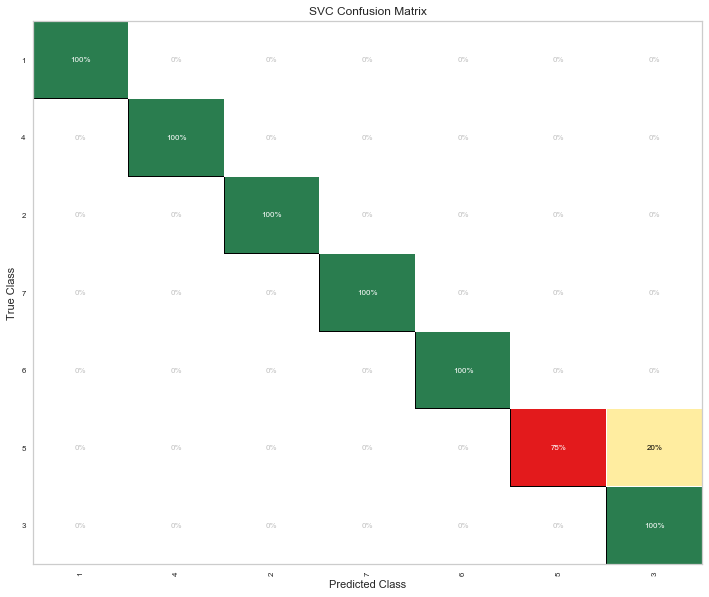

In [49]:
svc = make_pipeline(LDA(n_components=2), SVC(C=1, kernel='rbf', random_state=42))

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

In [53]:
bad = set()
for i,actual,pred in zip(np.arange(len(y)), y, svc.predict(X)):
    if actual != pred:
        bad.add(i)

In [54]:
bad

{93}

That's certainly an improvement over the previous iteration, but it's still pointless...we don't need to transform the data set if it's perfectly linearly separable. However, maybe it could help to generalize our model?

# SVM Hyperparameter Tuning

Now that we know the dataset is linearly separable, let's cross-validate the model to find the optimal hyperparameters. Although we performed perfectly on all of the data with a linear kernel, other kernels might generalize better, so the hyperparameters of interest will be **C**, **gamma**, and **kernel**.

In [26]:
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42) 

Cs = [.001, .01, .1, 1, 10]
gammas = [.001, .01, .1, 1]
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

param_grid = {'C':Cs, 'gamma':gammas, 'kernel':kernels}

n_folds = 3 # Number of folds must be less than number of obs in smallest class
grid_search = GridSearchCV(SVC(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

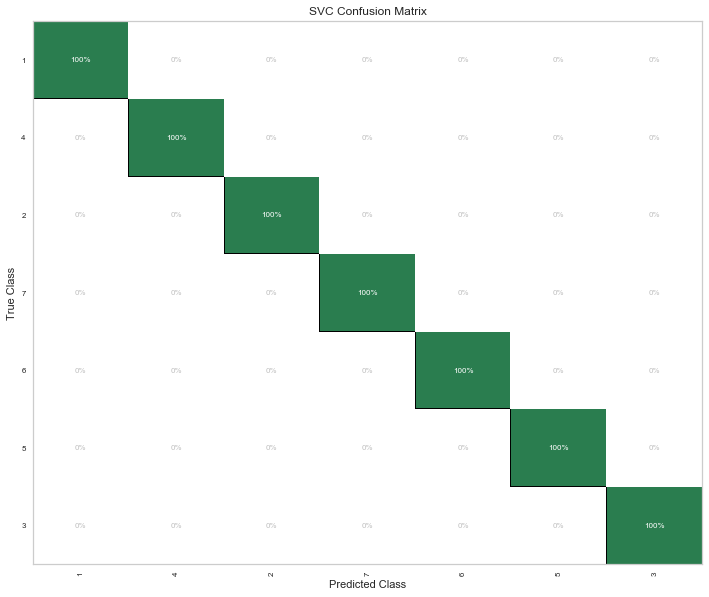

In [27]:
svc = SVC(**grid_search.best_params_)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X_train, y_train).score(X_test, y_test)
fig = cm.poof()

Alrighty then! It looks like my work here is done...we predicted test set perfectly. Based on the cross-validation, our optimal hyperparameters were a C of .1, gamma of 1, and polynomial kernel.

# K Nearest Neighbors Classifier

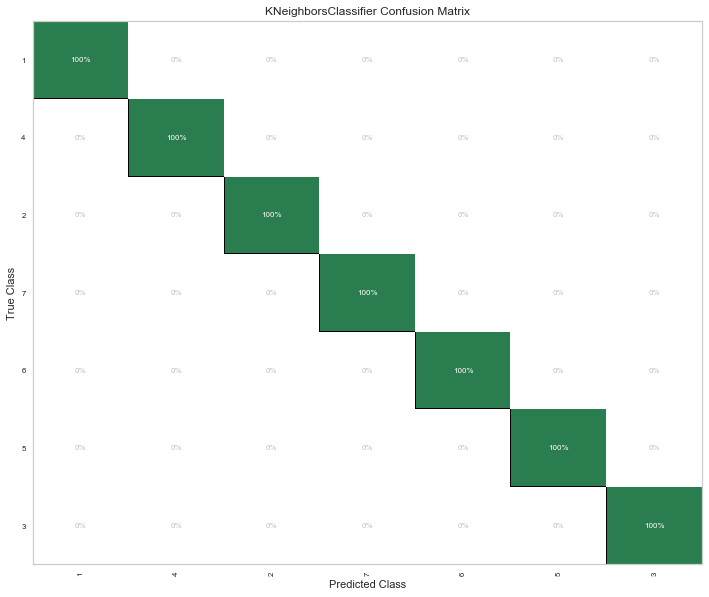

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(1)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(knc, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

# K Nearest Neighbors Cross-validation

In [29]:
n_neighbors = np.arange(1, 6)
metrics = ['euclidean', 'minkowski', 'jaccard', 'dice']
param_grid = {'n_neighbors': n_neighbors, 'metric':metrics}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([1, 2, 3, 4, 5]), 'metric': ['euclidean', 'minkowski', 'jaccard', 'dice']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

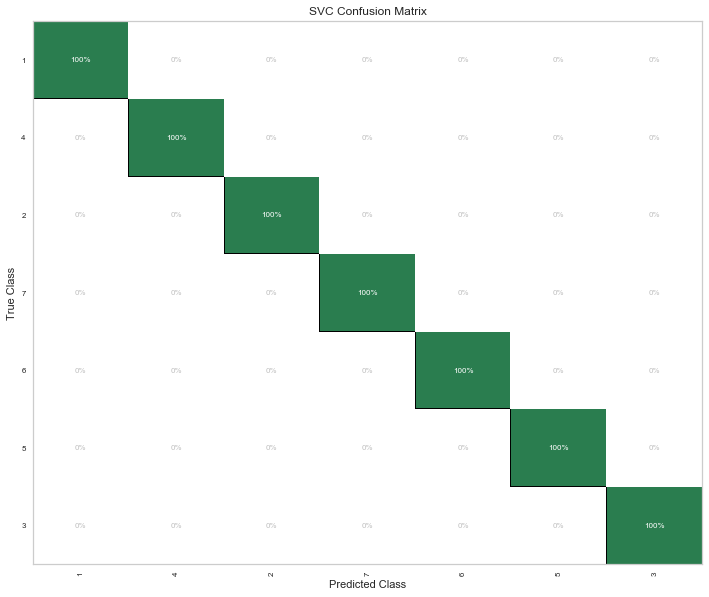

In [30]:
knc = KNeighborsClassifier(**grid_search.best_params_)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X_train, y_train).score(X_test, y_test)
fig = cm.poof()

# Gradient Boosting Machine

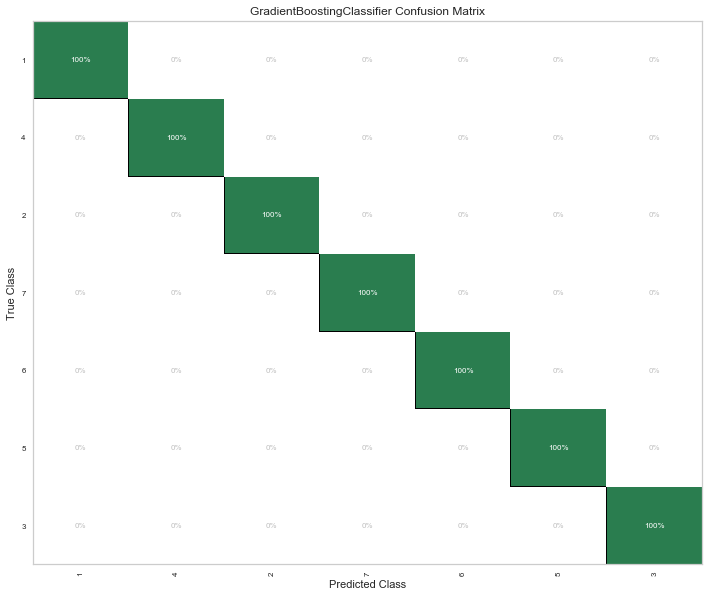

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

knc = GradientBoostingClassifier()

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(knc, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

In [32]:
n_estimators = np.arange(20,81,10)
max_depths = np.arange(5,16,2)
min_samples_splits = np.arange(200,1001,200)
max_features = np.arange(7,20,2)
param_grid = {'n_estimators': n_estimators, 
              'max_depth': max_depths, 
              'min_samples_split': min_samples_splits, 
              'max_features': max_features}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([20, 30, 40, 50, 60, 70, 80]), 'max_depth': array([ 5,  7,  9, 11, 13, 15]), 'min_samples_split': array([ 200,  400,  600,  800, 1000]), 'max_features': array([ 7,  9, 11, 13, 15, 17, 19])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [33]:
min_samples_splits = np.arange(20,31,5)
max_features = np.arange(16,21,1)
param_grid = {'min_samples_split': min_samples_splits, 
              'max_features': max_features}

grid_search = GridSearchCV(GradientBoostingClassifier(n_estimators=20, max_depth=5), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': array([20, 25, 30]), 'max_features': array([16, 17, 18, 19, 20])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

# Multilayer Perceptron

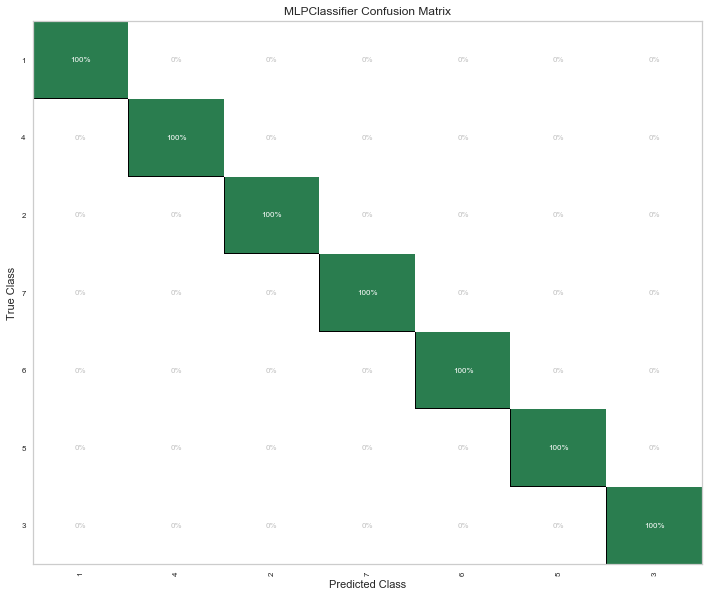

In [34]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(mlp, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

### TODO: Tune MLP Hyperparamters

In [35]:
param_grid = {}

grid_search = GridSearchCV(MLPerceptron(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([20, 30, 40, 50, 60, 70, 80]), 'max_depth': array([ 5,  7,  9, 11, 13, 15]), 'min_samples_split': array([ 200,  400,  600,  800, 1000]), 'max_features': array([ 7,  9, 11, 13, 15, 17, 19])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

mlp = RandomForestClassifier()

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(mlp, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

### TODO: Tune Random Forest Hyperparameters

In [ ]:
param_grid = {}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

# Testing

Let's see if we just got lucky with our cross-validation by simulating a variety of random seeds for splitting the data into test and train.

In [238]:
bad = [] # Incorrect predictions

In [239]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

def test_model(seed, est):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)
    if est == 'svc':
        params = {'C': .1, 'gamma': 1, 'kernel': 'poly'}
        model = SVC(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'knc':
        params = {'n_neighbors': 3, 'metric': 'euclidean'}
        model = KNeighborsClassifier(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'gbm':
        params = {'n_estimators': 20, 'max_depth': 5, 'max_features': 19, 'min_samples_split': 15}
        model = GradientBoostingClassifier(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'mlp':
        model = MLPClassifier().fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'rf':
        model = RandomForestClassifier().fit(X_train.drop(['animal_name'], axis=1), y_train)
    else:
        raise ValueError('est parameter must be svc, knc, gbm, or mlp')
        
    for animal_name,actual,pred in zip(X_train.animal_name, y_test, model.predict(X_test.drop(['animal_name'], axis=1))):

        if actual != pred:
#             if est == 'svc':
#                 print(est)
            bad.append((est, animal_name))
    
    return model.score(X_test.drop(['animal_name'], axis=1), y_test)

In [296]:
def simulate_model(n_simulations, est):
    scores = []
    for seed in range(n_simulations):
        if seed % 100 == 0: print(seed)
        scores.append(test_model(seed, est.lower()))
    print('The average accuracy for ' + est.upper() + ' across {} simulations was {:.2%}'.format(n_simulations, np.mean(scores)))
    return scores

In [304]:
import scipy.stats as stats

In [305]:
n_simulations = 1000
for estimator in ['svc', 'knc', 'gbm']:
    scores = simulate_model(n_simulations, estimator)
    print(pd.DataFrame(scores).describe())
    print(stats.mode(scores))

0
100
200
300
400
500
600
700
800
900
The average accuracy for SVC across 1000 simulations was 97.43%
                 0
count  1000.000000
mean      0.974308
std       0.027582
min       0.846154
25%       0.961538
50%       0.961538
75%       1.000000
max       1.000000
ModeResult(mode=array([ 0.96153846]), count=array([460]))
0
100
200
300
400
500
600
700
800
900
The average accuracy for KNC across 1000 simulations was 95.07%
                 0
count  1000.000000
mean      0.950692
std       0.035820
min       0.807692
25%       0.923077
50%       0.961538
75%       0.961538
max       1.000000
ModeResult(mode=array([ 0.96153846]), count=array([398]))
0
100
200
300
400
500
600
700
800
900
The average accuracy for GBM across 1000 simulations was 96.49%
                 0
count  1000.000000
mean      0.964923
std       0.035815
min       0.807692
25%       0.961538
50%       0.961538
75%       1.000000
max       1.000000
ModeResult(mode=array([ 1.]), count=array([398]))


| Model  | Accuracy  |
|:-------|----------:|
| SVC    | 97.57%    |
| KNC    | 95.10%    |
| GBM    | 97.42%    |
| MLP    | 96.47%    |
| RF     | 96.58%    |

In [261]:
bad_df = pd.DataFrame(bad, columns=['model', 'animal_name'])

In [262]:
bad_df.shape

(10675, 2)

In [263]:
bad_df = bad_df.merge(pd.DataFrame(animal_names), how='left')

In [264]:
bad_df.shape

(10874, 3)

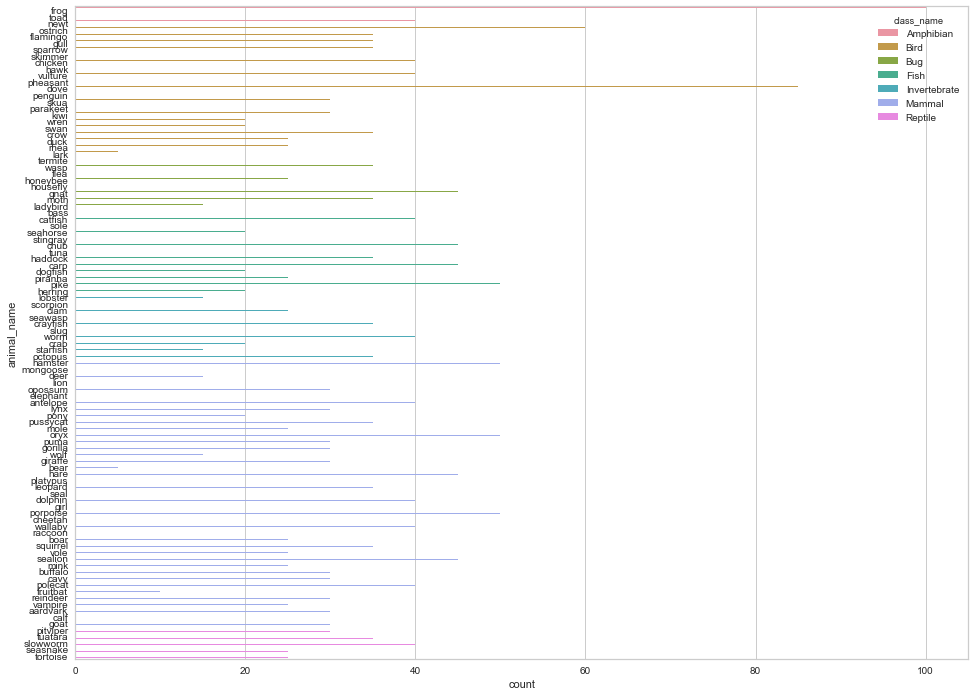

In [265]:
import seaborn as sns
plt.figure(figsize=(16,12))
g = sns.countplot(y='animal_name', hue='class_name', data=bad_df[bad_df.model == 'svc'].sort_values('class_name'), orient='v')

In [290]:
animal_counts = pd.DataFrame(bad_df.groupby('model').animal_name.value_counts())

In [291]:
animal_counts.columns = ['cnt']

In [294]:
animal_counts.groupby('model').sum()

,cnt
model,
gbm,944
knc,6540
svc,3390
